In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [3]:
diffusion_model = "256x256_diffusion_uncond" 

In [4]:
import gc
import io
import math
import sys
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')
import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

In [6]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1), interpolation=TF.InterpolationMode.BILINEAR),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.35),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(cutn):
            if ch > cutn - cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

def unitwise_norm(x, norm_type=2.0):
    if x.ndim <= 1:
        return x.norm(norm_type)
    else:
        return x.norm(norm_type, dim=tuple(range(1, x.ndim)), keepdim=True)

def adaptive_clip_grad(parameters, clip_factor=0.01, eps=1e-3, norm_type=2.0):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    for p in parameters:
        if p.grad is None:
            continue
        p_data = p.detach()
        g_data = p.grad.detach()
        max_norm = unitwise_norm(p_data, norm_type=norm_type).clamp_(min=eps).mul_(clip_factor)
        grad_norm = unitwise_norm(g_data, norm_type=norm_type)
        clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6))
        new_grads = torch.where(grad_norm < max_norm, g_data, clipped_grad)
        p.grad.detach().copy_(new_grads)

In [7]:
def regen_perlin():
    if perlin_mode == 'color':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
    elif perlin_mode == 'gray':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
    else:
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)

    init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
    del init2
    return init.expand(batch_size, -1, -1, -1)

def do_run():
    loss_values = []
    gc.collect()
    torch.cuda.empty_cache()
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # torch.backends.cudnn.deterministic = True
 
    make_cutouts = MakeCutouts(clip_size, cutn, skip_augs=skip_augs)
    target_embeds, weights = [], []
 
    for prompt in text_prompts:
        txt, weight = parse_prompt(prompt)
        txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()
        target_embeds.append(txt)
        weights.append(weight)
 
    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)
 
    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()
 
    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).unsqueeze(0).expand(batch_size, -1, -1, -1).to(device).mul(2).sub(1)
 
    cur_t = None
    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        x_in_grad = torch.zeros_like(x_in)

        for i in range(cutn_batches):
            clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
            image_embeds = clip_model.encode_image(clip_in).float()
            dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
            dists = dists.view([cutn, n, -1])
            losses = dists.mul(weights).sum(2).mean(0)
            loss_values.append(losses.sum().item())
            x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches

        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])
        sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
        loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        x_in_grad += torch.autograd.grad(loss, x_in)[0]
        grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
        adaptive_clip_grad([x])
        magnitude = grad.square().mean().sqrt()
        return grad * magnitude.clamp(max=clamp_max) / magnitude
 
    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive
 
    original_target_embeds = target_embeds.clone()
    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1
        gc.collect()
        torch.cuda.empty_cache()
        if fuzzy_prompt:
            target_embeds = original_target_embeds.clone() +  torch.randn_like(target_embeds).cuda() * rand_mag

        if perlin_init:
            init = regen_perlin()
 
        if model_config['timestep_respacing'].startswith('ddim'):
            samples = sample_fn(
                model,
                (batch_size, 3, side_y, side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_timesteps,
                init_image=init,
                randomize_class=randomize_class,
                eta=eta,
                cond_fn_with_grad=True,
            )
        else:
            samples = sample_fn(
                model,
                (batch_size, 3, side_y, side_x),
                clip_denoised=clip_denoised,
                model_kwargs={},
                cond_fn=cond_fn,
                progress=True,
                skip_timesteps=skip_timesteps,
                init_image=init,
                randomize_class=randomize_class,
                cond_fn_with_grad=True,
            )

        for j, sample in enumerate(samples):
            display.clear_output(wait=True)
            cur_t -= 1
            gc.collect()
            torch.cuda.empty_cache()
            if j % display_rate == 0 or cur_t == -1:
                for k, image in enumerate(sample['pred_xstart']):
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    for i in range(10):
                        gc.collect()
                        torch.cuda.empty_cache()
                    
                    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                    filename = f'progress_batch{i:05}_iteration{j:05}_output{k:05}.png'
                    image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                    image.save('./generations/' + filename)
                    display.display(display.Image('./generations/' + filename))
 
        #plt.plot(np.array(loss_values), 'r')

In [8]:
timestep_respacing = 'ddim100'
diffusion_steps = 1000
#diffusion_model = "512x512_diffusion_uncond_finetune_008100" #256x256_diffusion_uncond
model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    path = r'C:\Users\onuru\EEE443\Final_project\models\diff_512.pt'
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
        'use_checkpoint': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    path = r'C:\Users\onuru\EEE443\Final_project\models\diff_256.pt'
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
        'use_checkpoint': True,
    })
side_x = side_y = model_config['image_size']

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(path , map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

In [9]:
clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
check = torch.load('./model_fastai_b16.pth', map_location='cpu')
clip_model.load_state_dict(check['model'])
clip_size = clip_model.visual.input_resolution
normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\onuru\anaconda3\envs\dalle_n\lib\site-packages\lpips\weights\v0.1\vgg.pth


a room with blue walls and a white sink and door 
/ a black cat is inside a white toilet 
/ a brown and black horse in the middle of the city eating grass 
/ a woman walking her dog on the sidewalk 
/ a woman man and a dog standing in the snow

In [13]:
text_prompts = [
    'a room with blue walls and a white sink and door',
]

image_prompts = [
    # 'mona.jpg',
]

clip_guidance_scale = 15000 # 5000 (new:15000) - Controls how much the image should look like the prompt.
tv_scale = 2500 # 500 (new:2500) - Controls the smoothness of the final output.
range_scale = 100 # 100 - Controls how far out of range RGB values are allowed to be.
sat_scale = 0 # 0 - Controls how much saturation is allowed. From nshepperd's JAX notebook, though not sure if it's doing anything right now...
cutn = 32 # 16 - Controls how many crops to take from the image. Increase for higher quality.
cutn_batches = 1 # 2 - Accumulate CLIP gradient from multiple batches of cuts [Can help with OOM errors / Low VRAM]

init_image = None # None - URL or local path
init_scale = 0 # 0 - This enhances the effect of the init image, a good value is 1000
skip_timesteps = 5 # 10 (new:5) - Controls the starting point along the diffusion timesteps

# Try this option for random natural-looking noise in place of an init image:
perlin_init = True # False - Option to start with random perlin noise
perlin_mode = 'mixed' # 'mixed' ('gray', 'color')
if init_image is not None: # Can't combine init_image and perlin options
    perlin_init = False

skip_augs = False # False - Controls whether to skip torchvision augmentations
randomize_class = True # True - Controls whether the imagenet class is randomly changed each iteration
clip_denoised = True # False - Determines whether CLIP discriminates a noisy or denoised image
clamp_max = 0.035 # 0.05 (new:0.035)

fuzzy_prompt = False # False - Controls whether to add multiple noisy prompts to the prompt losses
rand_mag = 0.05 # 0.05 - Controls the magnitude of the random noise
eta = 0.5 # 0.5 - DDIM hyperparameter

In [19]:
gc.collect()
torch.cuda.empty_cache()

Batch 9, step 94, output 0:


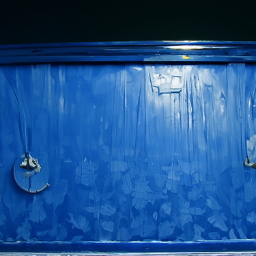

seed 213860645


In [20]:
display_rate = 1
n_batches = 1 # 1 - Controls how many consecutive batches of images are generated
batch_size = 1# 1 - Controls how many images are generated in parallel in a batch

#seed = 0
seed = random.randint(0, 2**32) # Choose a random seed and print it at end of run for reproduction

try:
    gc.collect()
    torch.cuda.empty_cache()
    do_run()
except KeyboardInterrupt:
    pass
finally:
    print('seed', seed)
    gc.collect()
    torch.cuda.empty_cache()